# Identificación de personas con gafas en imágenes

## Desarrollado por

* Juan Esteban Cendales Sora
* Daniel Exobar David
* Alejandro Jiménez Franco
* Juan José Sapuyes Pino
* Santiago Alexis Valencia Zapata

Universidad Nacional de Colombia - Sede Medellín
Colombia - 19/08/2021

## Introducción

### Conjunto de datos (Data Set)

El conjunto de datos dado por [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php) llamado [CMU Face Images Data Set](https://archive.ics.uci.edu/ml/datasets/CMU+Face+Images) se conforma por un conjunto de 20 subcarpetas nombradas con los pseudónimos de 20 personas:

* an2i
* at33
* boland
* bpm
* ch4f
* cheyer
* choon
* danieln
* glickman
* karyadi
* kawamura
* kk49
* megak
* mitchell
* night
* phoebe
* saavik
* steffi
* sz24
* tammo

Dentro de cada una de estas carpetas se encuentran entre 88 a 96 archivos de imágenes en blanco y negro con dos tipos de extensiones: `.pgm` y `.bad`. Las imágenes con la primera extensión se nombran de la siguiente manera:

`pseudónimo_dirección_emoción_gafas_x.pgm`

Donde:
* **pseudónimo**: se encuentra el correspondiente a la carpeta
* **dirección**: indica hacia dónde está mirando la persona fotografeada y puede tomar los valores de:
    + _left_ (izquierda)
    + _right_ (derecha)
    + _straight_ (de frente)
    + _up_ (arriba)
* **emoción**: indica la emoción expresada por la persona fotografeada y puede tomar los valores
    + _angry_ (enojado/a)
    + _happy_ (feliz)
    + _neutral_ (neutral)
    + _sad_ (triste)
* **gafas**: indica si la persona fotografeada lleva puestas unas gafas de sol o no con los valores:
    + _open_ (abierto/libre)
    + _sunglasses_ (gafas de sol)
* **x**: la x puede tomar un valor numérico para indicar en cuánto se ha reducido la resolución de la imagen en ese archivo. Las imágenes a las que no se les reduce la resolución no poseen esta última característica. Los valores pueden ser:
    + ninguno si la fotografía tiene la resolución original de $120 \times 128$ pixeles (15.360 pixeles)
    + _2_ si la reducción ha sido a la mitad de la original, es decir de $60 \times 64$ pixeles (3.840 pixeles)
    + _4_ si la reducción ha sido a un cuarto de la original, es decir de $30 \times 32$ pixeles (960 pixeles)
    
Por ejemplo, se pueden encontrar los siguientes archivos:

* `an2i_left_angry_open.pgm`
* `an2i_left_angry_open_2.pgm`
* `an2i_left_angry_open_4.pgm`

Estos archivos serían la misma fotografía pero con diferentes resoluciones.

Por otra parte, los archivos `.bad` se nombran de manera similar, a excepción que no tienen el indicativo de resolución, ya que estos archivos representan imágenes que quedaron mal tomadas debido a una mala configuración de la cámara al momento de tomar la foto. Por esta misma razón estas imágenes no se encuentran replicadas en diferentes resoluciones.

Así es que en realidad se tienen en cada carpeta, de 28 a 32 fotografías bien tomadas replicadas 3 veces en diferentes resoluciones y entre 0 a 4 fotografías mal tomadas, todas etiquetadas.

### Planteamiento del problema

Dado el conjunto de datos anterior, nos encontramos ante un problema de aprendizaje de máquina supervisado de clasificación binaria, ya que se pretende poder diferenciar las imágenes del conjunto de datos, en dos categorias: `con gafas de sol` o `sin gafas de sol`.

El principal reto a superar se encuentra en la baja cantidad de datos que se tienen para entrenamiento del modelo de clasificación, en comparación con la alta cantidad de variables de entrada, por lo que se contempla la posibilidad de hacer uso de técnicas de aumento de datos, al tiempo que se realiza un análisis de componentes principales para reducir la cantidad de variables de entrada, inspirándose en soluciones como las propuestas por Nikhil B (2017) o Huynh (2018).

## Implementación

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import random
import os
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Lectura y separación de los datos

Dada la forma en la que los datos se encuentran separados por carpetas, para simplificación del proceso, se separarán las imágenes solamente por su tamaño (definición) y por la variable de respuesta (si tiene gafas o no tiene gafas) en un árbol de carpetas de la siguiente manera:

* data
    + full
        - glasses
        - no_glasses
    + media
        - glasses
        - no_glasses
    + cuarto
        - glasses
        - no_glasses
    + bad

El último directorio será para seprarar las imágenes `.bad` del resto de las imágenes

Se define una constante con los nombres de las carpetas dónde se encuentran los archivos

In [2]:
carpetas = ['an2i', 'at33', 'boland', 'bpm', 'ch4f', 'cheyer', 'choon',
            'danieln', 'glickman', 'karyadi', 'kawamura', 'kk49', 'megak',
            'mitchell', 'night', 'phoebe', 'saavik', 'steffi', 'sz24', 'tammo']

Se recorren las carpetas para extraer las direcciones de las imágenes

In [3]:
direcciones_archivos =[]
direcciones_archivos_malos = []
for nombre in carpetas:
    direcciones_archivos += glob.glob(".\\faces\\"+nombre+"\\*.pgm")
    direcciones_archivos_malos += glob.glob(".\\faces\\"+nombre+"\\*.bad")

Generamos listas para separar los datos según su resolución (entera, media o de un cuarto) o si son malas (`bad`)

In [4]:
entera_imagenes = []
entera_nombres = []

media_imagenes = []
media_nombres = []

cuarto_imagenes = []
cuarto_nombres = []

malas_imagenes = []
malas_nombres = []

Creamos las carpetas para organizar y clasificar las imagenes según el modelo de carpetas planteado anteriormente

In [5]:
# Creo las carpetas para almacenar las imagenes segun su resolucion y si tienen o no gafas

if not os.path.exists('data'):
    os.makedirs('data')

if not os.path.exists('data/full'):
    os.makedirs('data/full')

if not os.path.exists('data/full/glasses'):
    os.makedirs('data/full/glasses')

if not os.path.exists('data/full/no_glasses'):
    os.makedirs('data/full/no_glasses')

if not os.path.exists('data/media'):
    os.makedirs('data/media')

if not os.path.exists('data/media/glasses'):
    os.makedirs('data/media/glasses')

if not os.path.exists('data/media/no_glasses'):
    os.makedirs('data/media/no_glasses')

if not os.path.exists('data/cuarto'):
    os.makedirs('data/cuarto')

if not os.path.exists('data/cuarto/glasses'):
    os.makedirs('data/cuarto/glasses')

if not os.path.exists('data/cuarto/no_glasses'):
    os.makedirs('data/cuarto/no_glasses')

if not os.path.exists('data/bad'):
    os.makedirs('data/bad')

if not os.path.exists('model'):
    os.makedirs('model')

Se itera sobre las direcciones de archivos para poblar las listas y las carpetas anteriores, segregando los archivos `pgm` de los `.bad`, además de por resolución, y por si tienen gafas o no, y se extrae los títulos de las imágenes dónde se encuentran las etiquetas de la información.

In [6]:
for direccion in direcciones_archivos:
    imagen = cv2.imread(direccion)
    # Simplificamos el título para quitar el ruido y dejar solo las etiquetas
    nuevo_nombre = direccion.split('\\')[3].replace(".pgm","").split("_")
    if "4" in nuevo_nombre:
        cuarto_imagenes.append(imagen)
        cuarto_nombres.append(nuevo_nombre[1:4])
        if nuevo_nombre[3] == 'open':
            #Guardamos las imagenes en su respectiva carpeta y cambiamos el tipo de archivo a jpg
            cv2.imwrite('data/cuarto/no_glasses/'+ "_".join(nuevo_nombre[0:4])+'.jpg', imagen)
        else:
            #Guardamos las imagenes en su respectiva carpeta y cambiamos el tipo de archivo a jpg
            cv2.imwrite('data/cuarto/glasses/'+ "_".join(nuevo_nombre[0:4])+'.jpg', imagen)
            
    elif "2" in nuevo_nombre:
        media_imagenes.append(imagen)
        media_nombres.append(nuevo_nombre[1:4])
        if nuevo_nombre[3] == 'open':
            #Guardamos las imagenes en su respectiva carpeta y cambiamos el tipo de archivo a jpg
            cv2.imwrite('data/media/no_glasses/'+ "_".join(nuevo_nombre[0:4])+'.jpg', imagen)
        else:
            #Guardamos las imagenes en su respectiva carpeta y cambiamos el tipo de archivo a jpg
            cv2.imwrite('data/media/glasses/'+ "_".join(nuevo_nombre[0:4])+'.jpg', imagen)
    else:
        entera_imagenes.append(imagen)
        entera_nombres.append(nuevo_nombre[1:])
        if nuevo_nombre[3] == 'open':
            #Guardamos las imagenes en su respectiva carpeta y cambiamos el tipo de archivo a jpg
            cv2.imwrite('data/full/no_glasses/'+ "_".join(nuevo_nombre)+'.jpg', imagen)
        else:
            #Guardamos las imagenes en su respectiva carpeta y cambiamos el tipo de archivo a jpg
            cv2.imwrite('data/full/glasses/'+ "_".join(nuevo_nombre)+'.jpg', imagen)

# Iteración sobre las imágenes malas
for direccion in direcciones_archivos_malos :
    imagen = cv2.imread(direccion)
    # Simplificamos el título para quitar el ruido y dejar solo las etiquetas
    nuevo_nombre = direccion.split('\\')[3].replace(".bad","").split("_")
    malas_imagenes.append(imagen)
    malas_nombres.append(nuevo_nombre[1:4])
    cv2.imwrite('data/bad/'+ "_".join(nuevo_nombre[0:4])+'.jpg', imagen)

### Análisis de los datos

Realizamos una selección aleatoria sobre los datos para mostrarlas en sus diferentes resoluciones

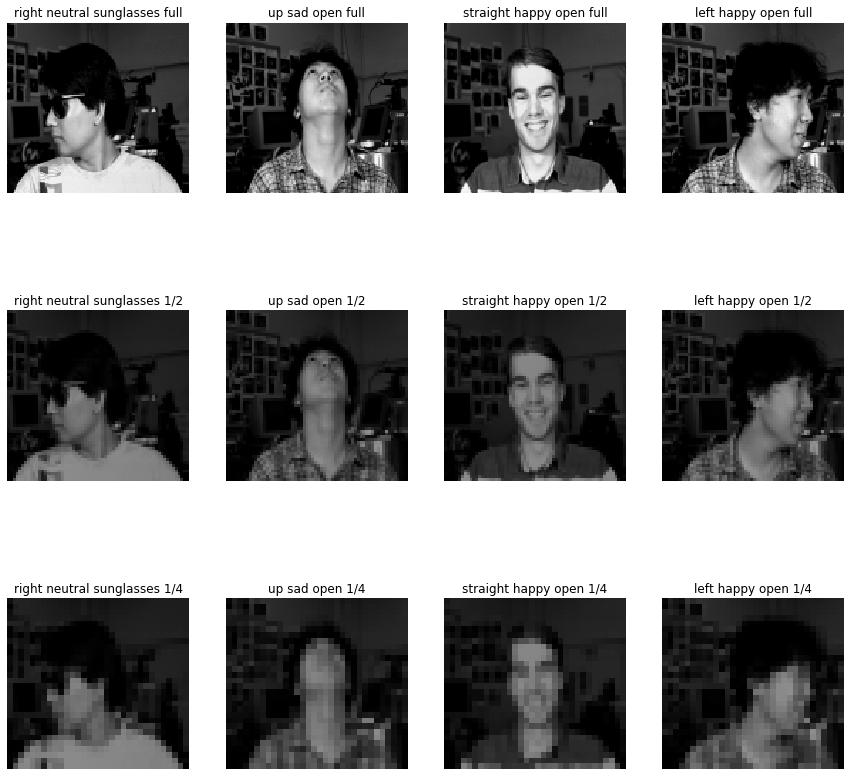

In [7]:
random.seed(123456)
elegidas = []
for i in range(0,4):
    elegidas.append(random.randint(0,len(entera_imagenes)))

plt.figure(figsize=(15, 15))
for i in range(12):
    ax= plt.subplot(3, 4, i + 1)
    if(0<=i<=3):
        plt.imshow(entera_imagenes[elegidas[i%4]])
        plt.title((" ".join(entera_nombres[elegidas[i%4]])+" full"))
    elif(4<=i<=7):
        plt.imshow(media_imagenes[elegidas[i%4]])
        plt.title((" ".join(media_nombres[elegidas[i%4]])+" 1/2"))
    else:
        plt.imshow(cuarto_imagenes[elegidas[i%4]])
        plt.title((" ".join(cuarto_nombres[elegidas[i%4]])+" 1/4"))
    plt.axis("off")

Como podemos observar, las imágenes coinciden pero tienen una resolución diferente, por lo que se debe optar por usar solo un conjunto de datos para evitar repeticiones

También podemos observar las imágenes malas

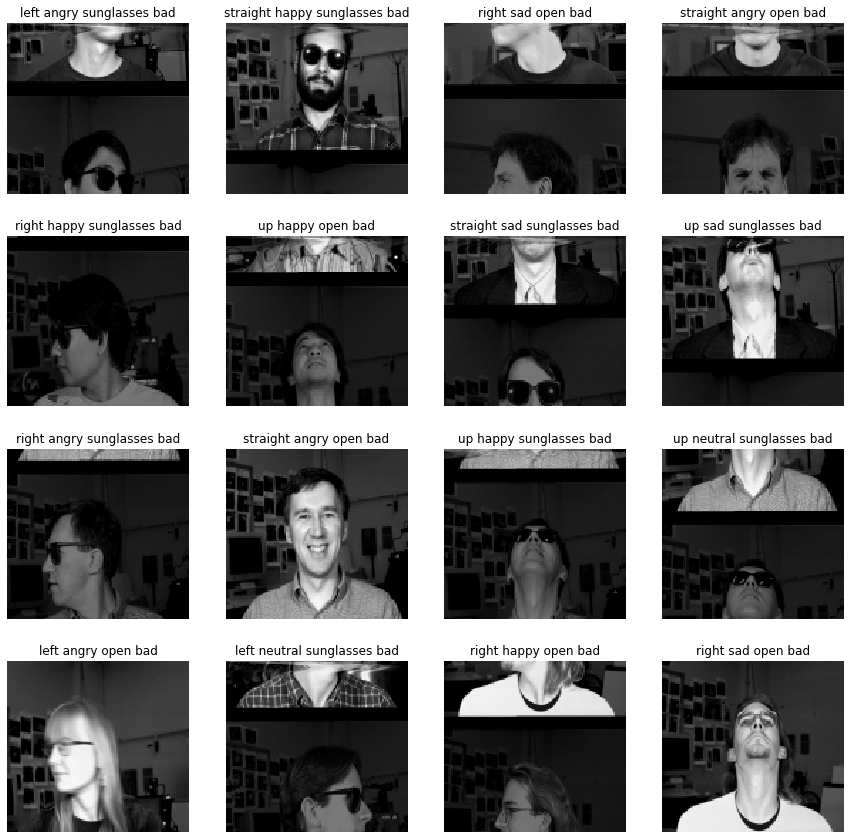

In [8]:
plt.figure(figsize=(15, 15))
for i in range(16):
    ax= plt.subplot(4, 4, i + 1)
    plt.imshow(malas_imagenes[i])
    plt.title((" ".join(malas_nombres[i])+" bad"))
    plt.axis("off")

Como podemos observar, las imágenes se encuentran borrosas o glicheadas, por lo que es completamente justificable descartarlas

In [9]:
cantidad_con_gafas = len(list(filter(lambda nombre: nombre[2] =="sunglasses",entera_nombres)))
cantidad_sin_gafas = len(list(filter(lambda nombre: nombre[2] =="open",entera_nombres)))

print("La cantidad de imágenes buenas sin repetición es de "+str(len(entera_imagenes))+
      ", repartidas entre "+str(cantidad_con_gafas)+" imágenes de personas con gafas y de "+
      str(cantidad_sin_gafas)+" imágenes de personas sin gafas en diferentes posiciones y expresiones")

La cantidad de imágenes buenas sin repetición es de 624, repartidas entre 311 imágenes de personas con gafas y de 313 imágenes de personas sin gafas en diferentes posiciones y expresiones


La cantidad de datos se reduce a 624 imágenes, pero a pesar de esto, las categorías se mantienen relativamente equilibradas

Bajo este panorama, inspirados en experiencias conjuntos de datos similares (Bueno Pérez, 2021) (Chernov, 2021) se decide aplicar dos modelos de redes neuronales pre-entrenadas desde la librería `tensorflow`, una sin y luego otra con tuneo. Para realizar este proceso con un conjunto de datos como con el que se cuenta, se recomienda un preprocesamiento de imágenes que contempla aumentación de datos y la extracción de componentes principales. Es por esto último que se determina hacer uso de las imágenes en resolución completa, buscando incluir la mayor cantidad de información posible, ya que de todas formas, esta va a ser resumida en el futuro.

### Preprocesamiento

Para realizar el preprocesamiento de los datos, también se hará uso de tensorflow, que provee de funciones que facilitan el proceso. Teniendo esto en cuenta, se ajustará el valor de algunos parámetros iniciales, como lo son el batch (tamaño de los paquetes de imágenes propagados por las redes neuronales) `batch sera igual a 10`, y el tamaño de imagen (alto, ancho) sera de $128\times128$ de esta forma, las imágenes podrán ser reescaladas para que tengan una forma cuadrada, algo que se requerirá en el futuro

In [10]:
BATCH_SIZE = 10
IMG_SIZE = (128, 128)

In [11]:
# Dirección de los datos
data_dir = "./data/full"

Agregamos un valor seed a tensorflow para la reproduccion de resultados

In [12]:
tf.random.set_seed(123456)

Separaremos los datos para ajustar el modelo de la siguiente manera:
- 70% datos de entrenamiento
- 30% datos de validación

In [13]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="training",
    shuffle=True,
    seed=123456,
    image_size= IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 624 files belonging to 2 classes.
Using 437 files for training.


In [14]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    shuffle=True,
    seed=123456,
    image_size= IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 624 files belonging to 2 classes.
Using 187 files for validation.


Verificamos la segmentación de clases  del modelo

In [15]:
#Las clases del modelo
class_names = train_dataset.class_names
print(class_names)

['glasses', 'no_glasses']


La siguiente muestra unas cuantas `imagenes del dataset de entrenamiento` alli se observa ambas clases:

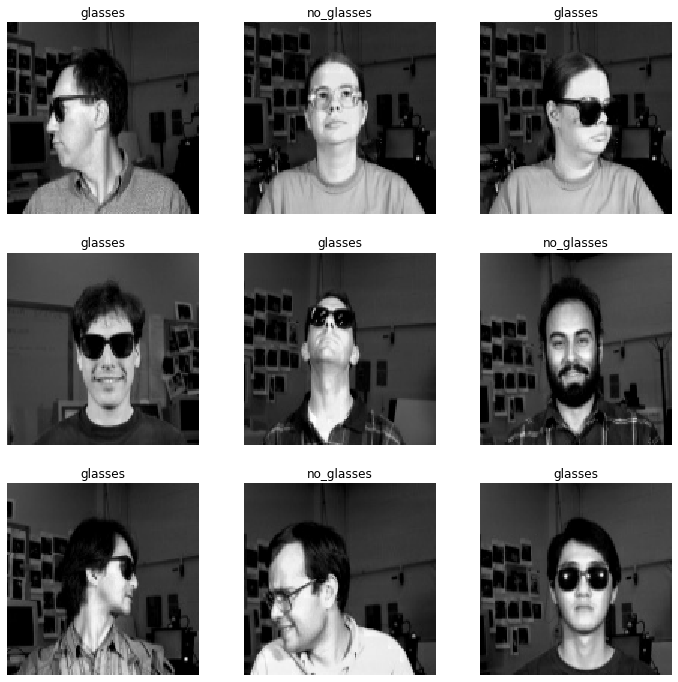

In [16]:
class_names = train_dataset.class_names

plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Basado en los ejemplos y la teoria se recomienda ademas de crear unos dataset de `entrenamiento` y `validación`, incluir un tercero de `testeo`. Este sera un `20% del dataset de validación`, esto es menos del `6%`

In [17]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [18]:
print('Numero de batches de entrenamiento: %d' % tf.data.experimental.cardinality(train_dataset))
print('Numero de batches de validación: %d ' % tf.data.experimental.cardinality(validation_dataset))
print('Numero de batches de testeo: %d' % tf.data.experimental.cardinality(test_dataset))

Numero de batches de entrenamiento: 44
Numero de batches de validación: 16 
Numero de batches de testeo: 3


Definimos los elementos de tuning para el modelo en el futuro

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Para este modelo añadiremos una tecnica de aumento para los datos, dada la cantidad de imagenes disponibles es recomendado siempre tener mas datos, esto de manera artificial, esto lo lograremos rotando las imagenes

In [20]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Miremos el resultado

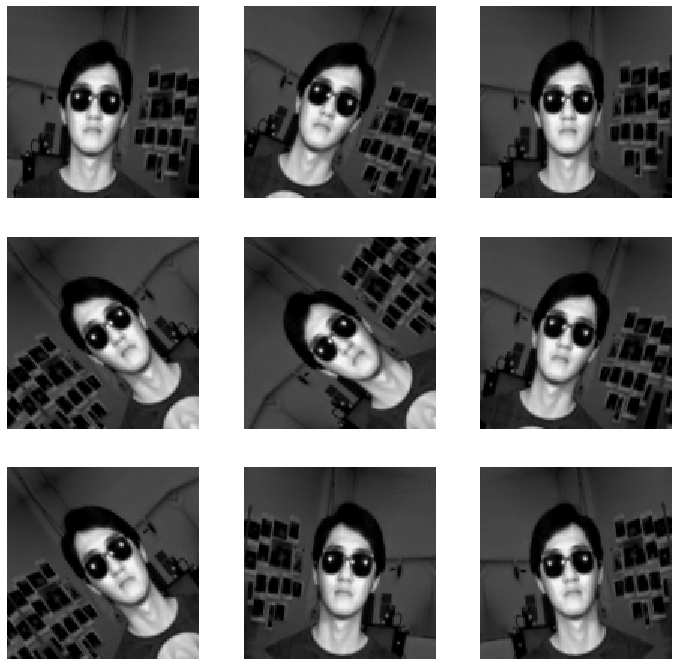

In [21]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(12, 12))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Ahora usaremos un base para el modelo usando una application llamada `MobileNetV2` (Sandler, 2018), y usaremos transferencia de conocimiento de la red pre-entrenada que sera descargada.

In [22]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Este modelo espera valores para los pixeles desde -1 a 1, asi que re escalaremos las imagenes

In [23]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

 El modelo base `MobileNet V2` fue desarrollado por Google
 Esta contiene un gran dataset de imagenes cerca de `1.4 billones de imagenes` y `1000 classes` (Sandler, 2018)

In [24]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

Este extractor de componentes principales convierte imagenes de `128x128x3` a `4x4x1280`

In [25]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(10, 4, 4, 1280)


In [26]:
componentes_originales = 128*128*3
componentes_extraidas = 4*4*1280
print("La reducción de componentes es de un",
      str((componentes_originales-componentes_extraidas)/(componentes_originales+componentes_extraidas)*100)+"%")

La reducción de componentes es de un 41.17647058823529%


In [27]:
# Usado para congelar la base convolucional de la red, por que usaremos el extractor componentes principales
base_model.trainable = False

Convertiremos con la capa `tf.keras.layers.GlobalAveragePooling2D` cada elemento en un vector de caracteristicas de 1280 por cada imagen

In [28]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(10, 1280)


In [29]:
componentes_originales = 128*128*3
componentes_extraidas = 1280
print("La reducción de componentes es de un",
      str((componentes_originales-componentes_extraidas)/(componentes_originales+componentes_extraidas)*100)+"%")

La reducción de componentes es de un 94.9238578680203%


`tf.keras.layers.Dense` es una capa que convirte el vector de caracteristicas en `una sola predicción`

In [30]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(10, 1)


### Implementación del modelo - Primer modelo, sin incluir las variables de tuning para el modelo

Ahora aplicaremos todo lo realizado anteriormente al modelo
- `Aumentar los datos`
- `Re escalado`
- `Un modelo base`
- `Un extractor de componentes principales`

In [31]:
inputs = tf.keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 128, 128, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 128, 128, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

Se compila el modelo con un _learning rate_ cercano a 0

In [33]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Hay `dos variables del objeto`. Dividido entre `2.5 billones del modelo base MobilNet` estos parametros estan `congelados`, y `1200` parametros de la capa `Dense`

In [34]:
len(model.trainable_variables)

2

**Entrenando el modelo**

Establecemos 15 epochs para evaluar entrenar el modelo

In [35]:
initial_epochs = 15
loss0, accuracy0 = model.evaluate(validation_dataset)

16/16 [==============================] - 3s 105ms/step - loss: 0.9469 - accuracy: 0.4395


In [36]:
print("'Loss' inicial: {:.2f}".format(loss0))
print("'Accuracy' inicial: {:.2f}".format(accuracy0))

'Loss' inicial: 0.95
'Accuracy' inicial: 0.44


Observamos que en un principio, con el primer epoch, el _accuracy_ nos muestra que el modelo funciona incluso peor que la adivinación con un 0.44 y presenta un _loss_ bastante alto, cercano a 1. Ejecutamos los demás epochs

In [37]:
model_fit = model.fit(train_dataset,
                    epochs= initial_epochs,
                    validation_data= validation_dataset)

Epoch 1/15
44/44 [==============================] - 11s 203ms/step - loss: 0.7285 - accuracy: 0.5378 - val_loss: 0.8014 - val_accuracy: 0.4841
Epoch 2/15
44/44 [==============================] - 9s 203ms/step - loss: 0.6486 - accuracy: 0.6201 - val_loss: 0.7372 - val_accuracy: 0.5669
Epoch 3/15
44/44 [==============================] - 8s 186ms/step - loss: 0.6199 - accuracy: 0.6522 - val_loss: 0.6639 - val_accuracy: 0.6051
Epoch 4/15
44/44 [==============================] - 8s 191ms/step - loss: 0.5456 - accuracy: 0.7071 - val_loss: 0.6057 - val_accuracy: 0.6815
Epoch 5/15
44/44 [==============================] - 8s 177ms/step - loss: 0.5215 - accuracy: 0.7254 - val_loss: 0.5716 - val_accuracy: 0.7452
Epoch 6/15
44/44 [==============================] - 8s 175ms/step - loss: 0.4976 - accuracy: 0.7643 - val_loss: 0.5299 - val_accuracy: 0.7452
Epoch 7/15
44/44 [==============================] - 8s 177ms/step - loss: 0.4573 - accuracy: 0.7689 - val_loss: 0.5076 - val_accuracy: 0.7707
Epoch

Se evalúa el _accuracy_ y el _loss_ a través de los diferentes epochs

In [38]:
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
loss_ = model_fit.history['loss']
val_loss_ = model_fit.history['val_loss']

Y se grafica

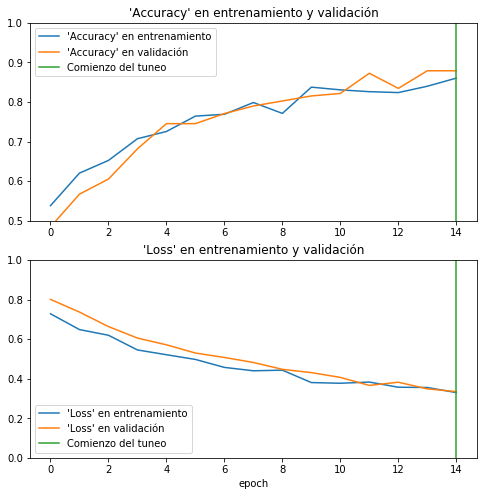

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="'Accuracy' en entrenamiento")
plt.plot(val_acc, label="'Accuracy' en validación")
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label="Comienzo del tuneo")
plt.legend(loc='upper left')
plt.title("'Accuracy' en entrenamiento y validación")

plt.subplot(2, 1, 2)
plt.plot(loss_, label="'Loss' en entrenamiento")
plt.plot(val_loss_, label="'Loss' en validación")
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label="Comienzo del tuneo")
plt.legend(loc='lower left')
plt.title("'Loss' en entrenamiento y validación")
plt.xlabel('epoch')
plt.show()

Se observa que en los primeros 5 epochs, el _accuracy_ aumenta significativamente, pasando del 0.44 a alrededor de 0.73 tanto para entrenamiento como para validación, incluso llegando a presentar un mejor _accuracy_ para los datos de validación, y de igual forma, el _loss_ se redujo de manera más o menos proporcional hasta el 5to epoch. De ahí en adelante, la mejoría en las métricas se mantiene pero de una manera más atenuada, presentándose un estancamiento en los epochs finales, dejando valores en el _accuracy_ tanto para entrenamiento como para validación alrededor de 0,86, y el _loss_ en alrededor de 0,33.

Se prueba el modelo con los datos de testeo

In [40]:
loss, accuracy = model.evaluate(test_dataset)
loss1, accuracy1 = model.evaluate(train_dataset)
loss2, accuracy2 = model.evaluate(validation_dataset)
print("'Accuracy' en test:", round(accuracy,2), "'Loss' en test:", round(loss,2))
print("'Accuracy' en entrenamiento:", round(accuracy1,2), "'Loss' en entrenamiento:", round(loss1,2))
print("'Accuracy' en validación:", round(accuracy2,2), "'Loss' en validación:", round(loss2,2))

16/16 [==============================] - 2s 127ms/step - loss: 0.3394 - accuracy: 0.8917
'Accuracy' en test: 0.77 'Loss' en test: 0.39
'Accuracy' en entrenamiento: 0.86 'Loss' en entrenamiento: 0.32
'Accuracy' en validación: 0.89 'Loss' en validación: 0.34


Las metricas que presenta el modelo con los datos de testeo son presentan una desmejoría significativa en comparación a las presentadas con los datos de entrenamiento y validación difiriendo en el _accuracy_ en 0.09 y 0.12 puntos menos respectivamente, y en el _loss_ 0.07 y 0.05 puntos por encima respectivamente. A pesar de que estas métricas son relativamente buenas, y superan por creces a la adivinación, es posible que se pueda aumentar el nivel de predicción que tiene.

### Segundo modelo, usando las tecnicas de tuneo en el modelo

Para este modelo usaremos los parametros de tuning anteriormente declarados y descongelaremos el modelo base para que los pesos se modifiquen en el entrenamiento

In [41]:
base_model.trainable = True

In [42]:
print("Numero de capas en el modelo base: ", len(base_model.layers))
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Numero de capas en el modelo base:  154


Compilando el modelo

In [43]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [44]:
len(model.trainable_variables)

56

In [45]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 128, 128, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 128, 128, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

Se observa que que las variables y los parámetros del modelo aumentan significativamente 

Se entrena el modelo, en esta ocación con tan solo 5 epochs, en comparación con los 15 anteriores

In [46]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

model_fit_fine = model.fit(train_dataset,
                         epochs= total_epochs,
                         initial_epoch= model_fit.epoch[-1],
                         validation_data= validation_dataset)

Epoch 15/20
44/44 [==============================] - 18s 318ms/step - loss: 0.3064 - accuracy: 0.8467 - val_loss: 0.1787 - val_accuracy: 0.9427
Epoch 16/20
44/44 [==============================] - 12s 275ms/step - loss: 0.1861 - accuracy: 0.9108 - val_loss: 0.1512 - val_accuracy: 0.9363
Epoch 17/20
44/44 [==============================] - 13s 284ms/step - loss: 0.1673 - accuracy: 0.9245 - val_loss: 0.1178 - val_accuracy: 0.9554
Epoch 18/20
44/44 [==============================] - 13s 289ms/step - loss: 0.1228 - accuracy: 0.9565 - val_loss: 0.0772 - val_accuracy: 0.9682
Epoch 19/20
44/44 [==============================] - 13s 301ms/step - loss: 0.0927 - accuracy: 0.9588 - val_loss: 0.0990 - val_accuracy: 0.9490
Epoch 20/20
44/44 [==============================] - 13s 293ms/step - loss: 0.1022 - accuracy: 0.9634 - val_loss: 0.0834 - val_accuracy: 0.9809


Evaluamos el _accuracy_ y el _loss_ después de la modificación y la agregamos a las métricas de los epochs del primer modelo

In [47]:
acc += model_fit_fine.history['accuracy']
val_acc += model_fit_fine.history['val_accuracy']
loss_ += model_fit_fine.history['loss']
val_loss_ += model_fit_fine.history['val_loss']

Graficamos los resultados

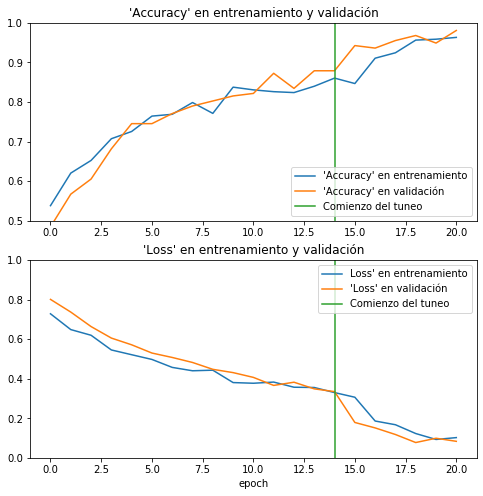

In [48]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="'Accuracy' en entrenamiento")
plt.plot(val_acc, label="'Accuracy' en validación")
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Comienzo del tuneo')
plt.legend(loc='lower right')
plt.title("'Accuracy' en entrenamiento y validación")

plt.subplot(2, 1, 2)
plt.plot(loss_, label="Loss' en entrenamiento")
plt.plot(val_loss_, label="'Loss' en validación")
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Comienzo del tuneo')
plt.legend(loc='upper right')
plt.title("'Loss' en entrenamiento y validación")
plt.xlabel('epoch')
plt.show()

Se observa que con la aplicación del tuneo, las métricas rompen con el estancamiento de mejora que venían presentando dando una mejora progresiva bastante significativa, llevando el _accuracy_ para entrenamiento a un 0.96 y para validación a un 0.98, valores muy cercanos al 1. A su vez, el _loss_ presenta valores de 0.10 para el entrenamiento y 0.08 para validación, acercándose bastante al 0. El modelo mejora significativamente en comparación con los resultados presentados previamente al tuneo

Probamos el nuevo modelo con los datos de testeo

In [49]:
loss, accuracy = model.evaluate(test_dataset)
loss1, accuracy1 = model.evaluate(train_dataset)
loss2, accuracy2 = model.evaluate(validation_dataset)
print("'Accuracy' en test:", round(accuracy,2), "'Loss' en test:", round(loss,2))
print("'Accuracy' en entrenamiento:", round(accuracy1,2), "'Loss' en entrenamiento:", round(loss1,2))
print("'Accuracy' en validación:", round(accuracy2,2), "'Loss' en validación:", round(loss2,2))

16/16 [==============================] - 2s 124ms/step - loss: 0.0830 - accuracy: 0.9809
'Accuracy' en test: 0.93 'Loss' en test: 0.08
'Accuracy' en entrenamiento: 0.97 'Loss' en entrenamiento: 0.07
'Accuracy' en validación: 0.98 'Loss' en validación: 0.08


En comparación con el modelo antes del tuneo, el _accuracy_ aumenta significativamente, con una diferencia de 0.16 puntos entre los resultados presentados. Así mismo, la brecha entre el _accuracy_ de los datos de entrenamiento y de validación se cierra, aún estando por debajo, pero con diferencias de 0.04 y 0.05 puntos respectivamente. De igual manera, la brecha entre el _loss_ de entrenamiento y validación, en comparación con los datos de testeo se reduce a no más de 0.02 puntos, lo cual es significativo dado que los valores se encuentran entre 0.07 y 0.08, valores muy cercanos al 0.

### Predicción y conclusiones

Observemos el modelo en funcionamiento con los datos de testeo

Predicciones en crudo:
 [ 9.191226  -3.532954  -4.6589575  9.241031   4.075278  -4.544374
 -0.5656456 -7.1820574 -2.4626322 -3.2915657]
Predicciones en crudo normalizadas:
 tf.Tensor(
[9.9989808e-01 2.8389007e-02 9.3874335e-03 9.9990296e-01 9.8329628e-01
 1.0515124e-02 3.6224219e-01 7.5957179e-04 7.8519642e-02 3.5861671e-02], shape=(10,), dtype=float32)
Predicciones:
 [1 0 0 1 1 0 0 0 0 0]
Etiquetas:
 [1 0 0 1 1 0 0 0 0 0]


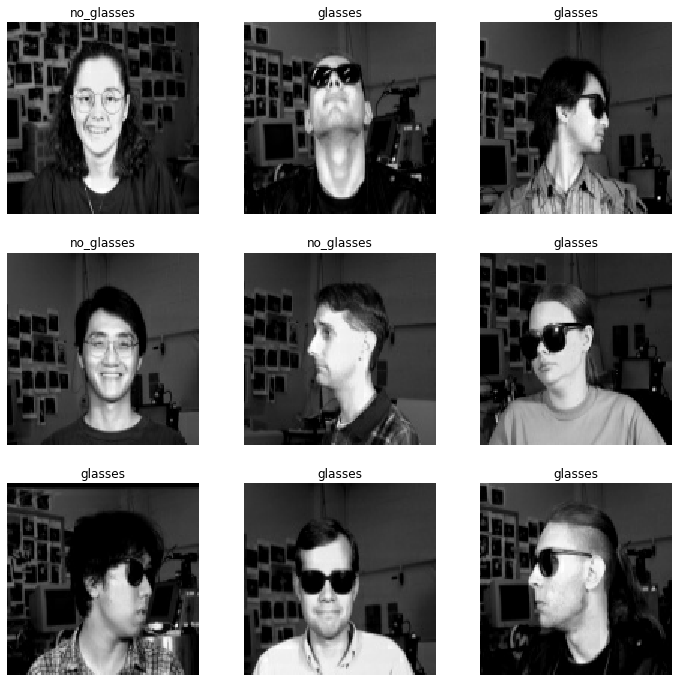

In [50]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

print('Predicciones en crudo:\n', predictions)

# Convierte los resultados crudos de la predicciones en valores entre 0 y 1 con la funsión sigmoide
predictions = tf.nn.sigmoid(predictions)

print('Predicciones en crudo normalizadas:\n', predictions)

#Transformamos las predicciones en valores binarios
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predicciones:\n', predictions.numpy())
print('Etiquetas:\n', label_batch)

plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

Se pudo observar que a pesar de la limitante de datos para el desarrollo del clasificador, y de la gran cantidad de variables de decisión, la implementación de técnicas de aumento de los datos y de extracción de componentes principales, a la par que se implementa un modelo de redes neuronales pre-entrenado, como la que provee MovileNetV2, en especial, al aplicar técnicas de tuneo, permite obtener un clasificador que determina para cada una de las imágenes del conjunto de datos inicial si la persona que aparece en la fotografía lleva o no unas gafas de sol con una tasa de acierto ( _accuracy_ ) por encima del 93% para todos los datos y una desviación respecto a la respuesta correcta ( _loss_ ) por debajo del 8%

### Exportación del modelo

Guardamos el modelo para su uso futuro dentro de la carpeta `model`

In [51]:
model_dir = ".\\model"
tf.saved_model.save(model, model_dir)

INFO:tensorflow:Assets written to: .\model\assets


In [52]:
loaded = tf.saved_model.load(model_dir)
print(list(loaded.signatures.keys()))

['serving_default']


In [53]:
with open('model.tflite', 'wb') as f:
    converter = tf.lite.TFLiteConverter.from_saved_model(model_dir)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()
    f.write(tflite_model)

with open('model-full.tflite', 'wb') as f:
    converter = tf.lite.TFLiteConverter.from_saved_model(model_dir)
    tflite_model = converter.convert()
    f.write(tflite_model)

## Referencias

* Bueno Pérez, J., 2021. Computer vision - Application of CNN. [Blog] Kaggle, Disponible en: <https://www.kaggle.com/jorgebuenoperez/computer-vision-application-of-cnn#3)-Preparing-base-model> [Accedido el 17 de Agosto del 2021].

* Chernov, A., 2021. Kaggle. [Blog] Glasses detection, Dsiponible en: <https://www.kaggle.com/lebegus/glasses-detection/notebook> [Accedido el 17 de Agosto del 2021].

* Huynh, N., 2018. Training on small image datasets for classify people who wearing sunglasses or gauze mask. [Blog] EyeQ Tech, Disponible en: <https://medium.com/@eyeq/training-on-small-image-datasets-for-classify-people-who-wearing-sunglasses-or-gauze-mask-5283bc3353d6> [Accedido el 16 de Agosto del 2021].

* Nikhil B, 2017. Fun with small image data-sets (Part 2). [Blog] Towards Data Science, Disponible en: <https://towardsdatascience.com/fun-with-small-image-data-sets-part-2-54d683ca8c96> [Accedido el 16 de Agosto del 2021].

* Sandler, M., 2018. MobileNetV2: The Next Generation of On-Device Computer Vision Networks. [Blog] Google AI Blog, Disponible en: <https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html> [Accedido el 16 de Agosto del 2021].